# 1.dfの作成

In [2]:
import pandas as pd

input = "../train/result0.xlsx"
df_all = pd.read_excel(input)

X_cols_SL = ["F14","F15","F16","F20","F0","R14","R15","R16","R20","R0"]
x_cols_hammett = ["Index 14","Index 15","Index 16","Index 20", "Index 0"]
y_cols_m = ["mwave1", "msrength1"]
y_cols_d = ["dwave1", "dstrength1"]

In [3]:
import numpy as np
import pandas as pd

def compute_scaled_distance_table(df, y_cols, target):
    """
    df:       pandas DataFrame
    y_cols:   目的変数カラム名のリスト（例: ['wavelength','osc_strength']）
    target:   numpy.array([530.64, 0.005])
    """

    Y = df[y_cols].values  # shape=(n_samples, 2)

    #--- スケール & オフセットを指定 ---
    # 波長  : 500 -> 530.64 を 1 に揃える => scale[0] = 530.64 - 500 = 30.64
    # 強度  :     0 -> 0.005  を 1 に揃える => scale[1] = 0.005
    scales = np.array([target[0] - 500.0,  target[1]])
    offsets = np.array([500.0,  0.0])

    #--- 変換後，理想値 (target) が [1,1] になるように ---
    Y_trans = (Y - offsets) / scales

    #--- [1,1] との差分 L2 ノルム を距離として採用 ---
    distances = np.linalg.norm(Y_trans - 1.0, axis=1)

    # 結果を DataFrame にまとめて返す
    return pd.DataFrame(
        {'distance_scaled': distances},
        index=df.index
    )

#――――――――――――――――――――――
# 使い方例
target = np.array([530.64, 0.005])
df_dist = compute_scaled_distance_table(df_all, y_cols_d, target)

# 小さい順に並べて出力
df_dist_sorted = df_dist.sort_values('distance_scaled')
df_dist_sorted.to_csv("../BO_result/distances/scaled_distance_table.csv")


PermissionError: [Errno 13] Permission denied: '../BO_result/distances/scaled_distance_table.csv'

# 2.FPの作成

In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

def create_fp_dataframe(df, smiles_col="dimer_smi", radius=2, n_bits=2048):
    """
    DataFrame から指定した SMILES 列を読み込み、Morgan フィンガープリント
    をビットベクトル化して新しい DataFrame として返す。

    Args:
        df (pd.DataFrame): 元の DataFrame（インデックスはそのまま利用）
        smiles_col (str): SMILES が入っているカラム名
        radius (int): Morgan fingerprint の半径
        n_bits (int): フィンガープリント長

    Returns:
        pd.DataFrame: 行数は df と同じ、列は FP_0～FP_{n_bits-1}
    """
    # 1. SMILES リスト取得
    smiles_list = df[smiles_col].tolist()
    
    # 2. フィンガープリント生成
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            fps.append(np.zeros(n_bits, dtype=int))
            continue
        bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=int)
        DataStructs.ConvertToNumpyArray(bv, arr)
        fps.append(arr)
    
    # 3. ndarray 化＆DataFrame 化
    fps_array = np.vstack(fps)  # shape = (len(df), n_bits)
    col_names = [f"FP_{i}" for i in range(n_bits)]
    df_fp = pd.DataFrame(fps_array, columns=col_names, index=df.index)
    
    return df_fp

# 使い方例

df_fp = create_fp_dataframe(df_all, smiles_col="dimer_smi", radius=2, n_bits=2048)
print(df_fp.shape)
df_fp.head()

# csv化
output_fp = "fp.csv"
df_fp.to_csv(output_fp, index=False)


[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerator
[15:54:46] DEPRECATION WARNING: please use MorganGenerat

(256, 2048)


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

def visualize_fp_substructures(df, smiles_col="dimer_smi",
                               radius=2, n_bits=2048, num_bits=8,
                               mols_per_row=4, subimg_size=(200,200)):
    """
    df の最初の SMILES について、フィンガープリントの
    上位 num_bits ビットに対応する原子環境をハイライト表示。
    PIL Image を直接表示します。
    """
    # 1) 分子取得
    smi = df.iloc[100][smiles_col]
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        raise ValueError("Invalid SMILES in first row")

    # 2) フィンガープリントと bitInfo
    bitInfo = {}
    _ = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, bitInfo=bitInfo)

    # 3) 上位 num_bits オンビット
    on_bits = list(bitInfo.keys())[:num_bits]

    # 4) ハイライト原子リスト作成
    highlight_lists = []
    legends = []
    for bit in on_bits:
        envs = bitInfo[bit]
        if not envs:
            highlight_lists.append([])
            legends.append(f"bit {bit}: none")
        else:
            atom_idx, rad = envs[0]
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
            amap = {}
            _ = Chem.PathToSubmol(mol, env, atomMap=amap)
            highlight_lists.append(list(amap.keys()))
            legends.append(f"bit {bit}")

    # 5) PIL Image を生成
    pil_img = Draw.MolsToGridImage(
        [mol] * len(highlight_lists),
        molsPerRow=mols_per_row,
        subImgSize=subimg_size,
        highlightAtomLists=highlight_lists,
        legends=legends
    )

    # 6) 直接表示
    display(pil_img)

# 使用例
# visualize_fp_substructures(df_all, smiles_col="dimer_smi", radius=2, n_bits=2048, num_bits=100)


In [4]:
df_all_FP = pd.concat([df_all, df_fp], axis=1)

# 3.小規模探索検証

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2
from scipy.stats import norm
from tqdm import trange, tqdm
import warnings


warnings.filterwarnings("ignore")

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    """
    L2-Lower Confidence Bound for multi-output GP via exact non-central chi-square.
    """
    k = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    # print(diff2)
    lam = diff2 / gamma2
    q = ncx2.ppf(1 - p, df=k, nc=lam)
    print(q)
    q = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    # print(f"p: {p}, k: {k}, gamma2: {gamma2.mean()}, diff2: {diff2.mean()}, lam: {lam.mean()}, q: {q.mean()}")
    return - np.sqrt(q * gamma2)

def l2_lcb_per_dim(means: np.ndarray,
                   variances: np.ndarray,
                   target: np.ndarray,
                   p: float = 0.05,
                   eps: float = 1e-8) -> np.ndarray:

    # 1) prevent zero variances
    vars_safe = np.maximum(variances, eps)
    # 2) compute non-centrality λ for each candidate
    lam = np.sum((means - target)**2 / vars_safe, axis=1)
    # 3) inverse survival function: P(X ≥ q) = p for χ²ₖ(λ)
    q   = ncx2.isf(p, df=means.shape[1], nc=lam)
    # 4) score = −q (we pick argmax scores ⇒ minimize q)
    print(variances)
    return -q

def l2_lcb_per_dim_euclid(
    means: np.ndarray,      # shape = (n_cand, n_obj)
    variances: np.ndarray,  # shape = (n_cand, n_obj)
    target: np.ndarray,     # shape = (n_obj,)
    p: float = 0.05,
    eps: float = 1e-8
) -> np.ndarray:
    """
    各候補点 i, 各目的関数 j について
      • lam_ij = (μ_ij – target_j)^2 / var_ij
      • q_ij   = χ²₁(non-central λ=lam_ij) の上側 p% 点
      • d2_ij  = q_ij * var_ij  （「ズレ²」の worst‐case 上限推定）
      • d_ij   = sqrt(d2_ij)    （「ズレ」の worst‐case 上限推定）
    → 最後に各 i についてベクトル d_i を L₂ ノルムでまとめ、
      小さいほど良いスコア −dist_i を返す。
    """
    # 1) ゼロ分散回避
    vars_safe = np.maximum(variances, eps)
    #   → 分散が 0 に近いとき数値が爆発するのを防ぐ

    # 2) non-centrality λ の計算
    lam = (means - target[np.newaxis, :])**2 / vars_safe
    #   lam_ij = ((μ_ij – target_j)^2) / var_ij

    # 3) df=1 の非心χ² 上側 p% 点 q_ij を求める
    q = ncx2.isf(p, df=1, nc=lam)
    #   → P(X ≥ q_ij) = p を満たす閾値 q_ij

    # 4) 「ズレ²」の worst‐case 上限推定 d2_ij = q_ij * var_ij
    d2 = q * vars_safe

    # 5) 「ズレ」の worst‐case 上限推定 d_ij = sqrt(d2_ij)
    d = np.sqrt(d2)

    # 6) 各候補 i のベクトル d_i の L2 ノルム dist_i を計算
    dist = np.linalg.norm(d, axis=1)
    #   → 次元ごとの worst‐case 距離を合成して「全体の worst‐case 距離」を得る
    # print(dist)
    # 7) 獲得関数用に、小さい距離を良しとするようマイナス符号をつけて返す
    return -dist


def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    """
    L2-Expected Improvement for multi-output GP via non-central chi-square.
    """
    k = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    nc = diff2 / gamma2
    y_min = 0.15**2
    x = y_min / gamma2
    t1 = y_min * ncx2.cdf(x, df=k, nc=nc)
    t2 = gamma2 * (
        k   * ncx2.cdf(x, df=k+2, nc=nc)
      + nc  * ncx2.cdf(x, df=k+4, nc=nc)
    )
    return np.maximum(0, t1 - t2)




def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    """各出力次元ごとに GPy の GPRegression をフィッティングしてリストで返す。"""
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=False)
        m = GPy.models.GPRegression(X, Y[:, [i]], kern)
        # m.Gaussian_noise.variance = 1e-6
        # m.Gaussian_noise.variance.fix()
        m.optimize(messages=False,max_iters=5)
        models.append(m)
        # print(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    """リスト化した GPRegression モデル群で予測し、平均と分散の配列を返す。"""
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def export_sorted_distances_to_csv(Y: np.ndarray,
                                   target: np.ndarray,
                                   filename: str = "/Users/macmini/Documents/distances_to_target.csv"):
    """
    全候補点 Y と target のユークリッド距離を計算し、
    距離が小さい順にソートした結果を CSV に書き出す。
    """
    dists = np.linalg.norm(Y - target.reshape(1, -1), axis=1)
    order = np.argsort(dists)
    df_out = pd.DataFrame({
        "index": order,
        "distance": dists[order]
    })
    df_out.to_csv(filename, index=False)
    print(f"Sorted distances saved to {filename}")



In [40]:
import numpy as np
import pandas as pd
import GPy
from scipy.stats import ncx2
from tqdm import trange
import warnings

warnings.filterwarnings("ignore")

def compare_all_methods(
    df: pd.DataFrame,
    X_cols: list,
    Y_cols: list,
    target: np.ndarray,
    hit_threshold: float,
    methods: list,
    init_size: int = 5,
    trials: int = 50,
    p: float = 0.05,
    budget: int = None,
    eps: float = 1e-8
):
    """
    複数の獲得関数で BO を比較し、以下を返す:
      - hit count: ピックした点のうち距離 < hit_threshold の累積ヒット数
      - cumulative regret per objective
      - picks の index と Y 値
      - 平均獲得関数値

    スケーリング:
      Y_scaled[:,0] = (Y[:,0] - 500) / (target[0] - 500)
      Y_scaled[:,1] =  Y[:,1]      / target[1]
    理想点は常に [1,1] として距離を計算。
    """
    # データ行列
    X_all = df[X_cols].values              # shape: (N, n_features)
    Y_all = df[Y_cols].values              # shape: (N, n_obj)
    N     = len(df)
    if budget is None:
        budget = N - init_size
    n_obj = Y_all.shape[1]

    # オフセット・スケール
    offsets = np.array([500.0, 0.0])
    scales  = np.array([target[0] - 500.0, target[1]])

    # 全データのスケーリング済み距離（閾値比較用）
    Y_scaled_all = (Y_all - offsets) / scales
    dist_all     = np.linalg.norm(Y_scaled_all - 1.0, axis=1)

    # 結果格納用配列
    hit_hist    = {m: np.zeros((trials, budget))         for m in methods}
    regret_hist = {m: np.zeros((trials, budget, n_obj))  for m in methods}
    picks_idx   = {m: np.zeros((trials, budget), dtype=int) for m in methods}
    picks_Y     = {m: np.zeros((trials, budget, n_obj))  for m in methods}
    acq_hist    = {m: np.zeros((trials, budget))         for m in methods}
    acq_mean_hist = {m: np.zeros((trials, budget))         for m in methods}

    # メインループ
    for run in trange(trials, desc="Trials"):
        rng  = np.random.RandomState(run + 1)
        perm = rng.permutation(N)
        train_base = perm[:init_size].tolist()
        cand_base  = perm[init_size:].tolist()

        for m in methods:
            train_idx = train_base.copy()
            cand_idx  = cand_base.copy()

            # ← 初期訓練セット中のヒット数をカウント
            cum_hits = sum(dist_all[i] < hit_threshold for i in train_idx)
            cum_reg  = np.zeros(n_obj)

            # 初期モデル構築 (GPy マルチ出力モデル)
            if m in ('lcb', 'ei'):
                Y_tr_s = (Y_all[train_idx] - offsets) / scales
                models = fit_multi_gpy(X_all[train_idx], Y_tr_s)

            # BO イテレーション
            for it in range(budget):
                X_cd = X_all[cand_idx]
                if m == 'lcb':
                    mu, var = predict_multi_gpy(models, X_cd)
                    target = np.array([1.0, 1.0])
                    scores  = l2_lcb_per_dim_euclid(mu, var, target, p, eps)
                    

                elif m == 'ei':
                    mu, var = predict_multi_gpy(models, X_cd)
                    Y_tr_s  = (Y_all[train_idx] - offsets) / scales
                    y_min   = np.min(np.linalg.norm(Y_tr_s - 1.0, axis=1))

                    # print(f"y_min{y_min}")
                    scores  = l2_ei(mu, var, 1.0, y_min, eps)
                else:  # 'rand'
                    scores = None

                # 次点選択
                if scores is not None:
                    pick = np.argmax(scores)
                    acq_hist[m][run, it] = scores[pick]
                    acq_mean_hist[m][run, it] = np.mean(scores)
                else:
                    pick = rng.randint(len(cand_idx))

                idx_pick = cand_idx.pop(pick)
                train_idx.append(idx_pick)

                # hit count 更新
                if dist_all[idx_pick] < hit_threshold:
                    cum_hits += 1
                hit_hist[m][run, it] = cum_hits

                # cumulative regret 更新
                y_new = Y_all[idx_pick]
                y_new_scaled = (y_new - offsets) / scales
                target = np.array([1.0, 1.0])
                cum_reg += np.abs(y_new_scaled- target)
                regret_hist[m][run, it] = cum_reg

                # picks 保存
                picks_idx[m][run, it] = idx_pick
                picks_Y[m][run, it]   = y_new

                # モデル更新
                if m in ('lcb', 'ei'):
                    X_tr   = X_all[train_idx]
                    Y_tr_s = (Y_all[train_idx] - offsets) / scales
                    for mdl in models:
                        i = models.index(mdl)
                        mdl.set_XY(X_tr, Y_tr_s[:, [i]])
                        mdl.optimize(messages=False, max_iters=5)

    # DataFrame に組み立て
    iterations = np.arange(1, budget + 1)

    df_hits = pd.DataFrame(
        {m: hit_hist[m].mean(axis=0) for m in methods},
        index=iterations
    )
    df_hits.index.name = 'iteration'

    df_regret = {
        m: pd.DataFrame(
            regret_hist[m].mean(axis=0),
            columns=Y_cols,
            index=iterations
        ) for m in methods
    }

    df_picks = {
        m: pd.DataFrame(
            picks_idx[m],
            index=[f"run{r+1}" for r in range(trials)],
            columns=[f"iter{t}" for t in iterations]
        ) for m in methods
    }

    df_Y = {
        m: {
            col: pd.DataFrame(
                picks_Y[m][:, :, i],
                index=[f"run{r+1}" for r in range(trials)],
                columns=[f"iter{t}" for t in iterations]
            )
            for i, col in enumerate(Y_cols)
        } for m in methods
    }

    df_acq = pd.DataFrame(
        {m: acq_hist[m].mean(axis=0) for m in methods},
        index=iterations
    )
    df_acq.index.name = 'iteration'

    df_acq_mean = pd.DataFrame(
        {m: acq_mean_hist[m].mean(axis=0) for m in methods},
        index=iterations
    )
    df_acq_mean.index.name = 'iteration'

    return df_hits, df_regret, df_picks, df_Y, df_acq, df_acq_mean


In [7]:
# X_cols_FP = [f"FP_{i}" for i in range(2048)]
# for i, v in enumerate(X_cols_FP):
#     print(f"{i:3d}: {v}")


# df_FPの0しかないカラムを抜く
df_FP_NONE0 = df_fp.loc[:, (df_fp != 0).any(axis=0)]
X_cols_FP_NONE0 = df_FP_NONE0.columns.tolist()
print(f"FP columns with non-zero values: {len(X_cols_FP_NONE0)}")

# df_FPの1しかないカラムを抜く
df_FP_NONE1 = df_fp.loc[:, (df_fp != 1).any(axis=0)]
X_cols_FP_NONE1 = df_FP_NONE1.columns.tolist()
print(f"FP columns with non-one values: {len(X_cols_FP_NONE1)}")


df_all_FP = pd.concat([df_all, df_fp], axis=1)
# ユニーク値の種類数が「1より大きい」カラムだけを残す
df_FP_NONE1 = df_fp.loc[:, df_fp.nunique(dropna=False) > 1]

# カラム名リスト
X_cols_FP = df_FP_NONE1.columns.tolist()
print(f"FP columns with more than one unique value: {len(X_cols_FP)}")


FP columns with non-zero values: 213
FP columns with non-one values: 2024
FP columns with more than one unique value: 189


# FPでのBO


In [41]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq, df_acq_mean= compare_all_methods(
    df_all_FP, X_cols_FP_NONE0 , y_cols_d, target,hit_threshold=0.15,
    methods=('lcb','rand'),
    init_size=5, trials=1, p=0.95, budget=None
)

Trials: 100%|██████████| 1/1 [00:16<00:00, 16.83s/it]


In [43]:
# ファイルの保存
file_initial = "../FP_test"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
# df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
# df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
# df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
# df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
# df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
# df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
# df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

# df_acq.to_csv(f"{file_initial}_acq.csv")
df_acq_mean.to_csv(f"{file_initial}_acq_mean.csv")

# HammettでのBO

In [26]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq, df_acq_mean = compare_all_methods(
    df_all_FP, x_cols_hammett , y_cols_d, target,hit_threshold=0.15,
    methods=('lcb','rand'),
    init_size=5, trials=1, p=0.95, budget=251
)


Trials: 100%|██████████| 1/1 [00:13<00:00, 13.25s/it]


In [29]:
# ファイルの保存
file_initial = "../Hammett_test"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
# df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
# df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
# df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
# df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
# df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
# df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
# df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# Hammett + FP

In [37]:
X_cols_FP_Hammett = X_cols_FP + x_cols_hammett
print(f"Combined FP and Hammett columns: {len(X_cols_FP_Hammett)}")
FP_Hammett_scaler = StandardScaler()
scaled_X_FP_Hammett = FP_Hammett_scaler.fit_transform(df_all_FP[X_cols_FP_Hammett])
df_all_scaled = pd.concat([df_all_FP[y_cols_d], pd.DataFrame(scaled_X_FP_Hammett, columns=X_cols_FP_Hammett)], axis=1)
df_all_scaled 


Combined FP and Hammett columns: 194


,dwave1,dstrength1,FP_24,FP_33,FP_81,FP_84,FP_94,FP_115,FP_133,FP_138,...,FP_1983,FP_1996,FP_1999,FP_2037,FP_2042,Index 14,Index 15,Index 16,Index 20,Index 0
0,543.099536,0.0027,-0.125988,-0.125988,-0.625543,-1.133893,-0.480384,-0.125988,-0.221766,-0.221766,...,-0.221766,-0.125988,-0.258199,-0.625543,-0.221766,-0.205959,-0.617254,-0.205959,-0.205959,-0.205959
1,557.783845,0.0023,-0.125988,-0.125988,-0.625543,-1.133893,-0.480384,-0.125988,-0.221766,-0.221766,...,-0.221766,-0.125988,-0.258199,-0.625543,-0.221766,-0.205959,-0.617254,-0.205959,-0.617876,-0.617876
2,563.231695,0.0022,-0.125988,-0.125988,-0.625543,-1.133893,-0.480384,-0.125988,-0.221766,-0.221766,...,-0.221766,-0.125988,-0.258199,-0.625543,-0.221766,-0.205959,-0.617254,-0.205959,-0.860180,-0.860180
3,597.456597,0.0060,-0.125988,-0.125988,-0.625543,-1.133893,-0.480384,-0.125988,-0.221766,-0.221766,...,-0.221766,-0.125988,-0.258199,-0.625543,-0.221766,-0.205959,-0.617254,-0.205959,1.684014,1.684014
4,520.832569,0.0037,-0.125988,-0.125988,-0.625543,-1.133893,-0.480384,-0.125988,-0.221766,-0.221766,...,-0.221766,-0.125988,3.872983,-0.625543,-0.221766,-0.205959,-0.617254,-0.617876,-0.205959,-0.205959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,549.088543,0.0099,-0.125988,-0.125988,1.598611,0.881917,-0.480384,-0.125988,-0.221766,-0.221766,...,-0.221766,-0.125988,-0.258199,1.598611,-0.221766,1.684014,1.689327,-0.860180,1.684014,1.684014
252,654.926803,0.0022,-0.125988,-0.125988,1.598611,0.881917,-0.480384,-0.125988,-0.221766,-0.221766,...,-0.221766,-0.125988,-0.258199,1.598611,-0.221766,1.684014,1.689327,1.684014,-0.205959,-0.205959
253,696.266597,0.0019,-0.125988,-0.125988,1.598611,0.881917,-0.480384,-0.125988,-0.221766,-0.221766,...,-0.221766,-0.125988,-0.258199,1.598611,-0.221766,1.684014,1.689327,1.684014,-0.617876,-0.617876
254,788.553031,0.0013,-0.125988,-0.125988,1.598611,0.881917,-0.480384,-0.125988,-0.221766,-0.221766,...,-0.221766,-0.125988,-0.258199,1.598611,-0.221766,1.684014,1.689327,1.684014,-0.860180,-0.860180


In [25]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_scaled, X_cols_FP_Hammett , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=5, trials=50, p=0.7, budget=251
)


Trials: 100%|██████████| 50/50 [38:01<00:00, 45.63s/it]


In [ ]:
# ファイルの保存
file_initial = "../BO_result/initsize5_LCB_per_dim_EI_05/FP+Hammett/FP+Hammett_p_0.7_init5"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# FP初期点50

In [46]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_FP, X_cols_FP_NONE0 , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=100, trials=50, p=0.7, budget=None
)


Trials: 100%|██████████| 50/50 [31:55<00:00, 38.31s/it]


In [48]:
# ファイルの保存
file_initial = "../BO_result/initsize100_LCB_per_dim/FP/FP_p_0.7_init5"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# Hammett初期点50


In [49]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_FP, x_cols_hammett , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=100, trials=50, p=0.7, budget=None
)

Trials: 100%|██████████| 50/50 [19:04<00:00, 22.89s/it]


In [50]:
# ファイルの保存
file_initial = "../BO_result\initsize100_LCB_per_dim/Hammett/Hammett_p_0.7_init5"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# FP + Hammett 初期点50

In [51]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_scaled, X_cols_FP_Hammett , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=100, trials=50, p=0.7, budget=None
)


Trials: 100%|██████████| 50/50 [3:56:56<00:00, 284.33s/it]   


In [52]:
# ファイルの保存
file_initial = "../BO_result/initsize100_LCB_per_dim/FP+Hammett/FP+Hammett_p_0.7_init5"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# 可視化

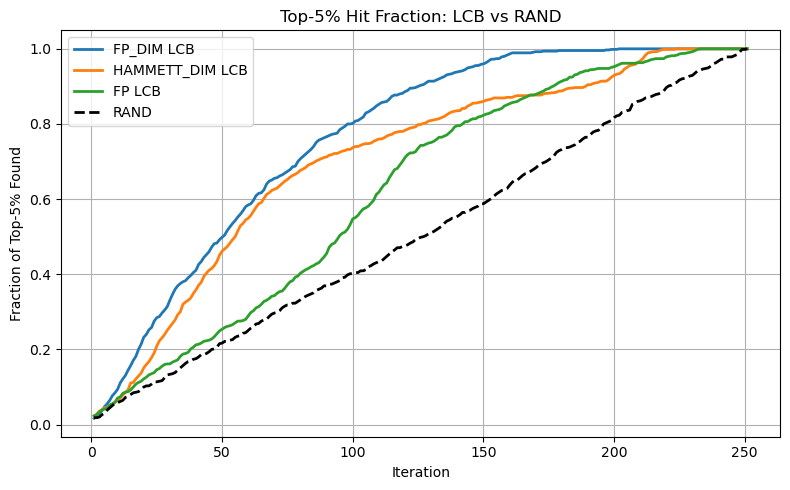

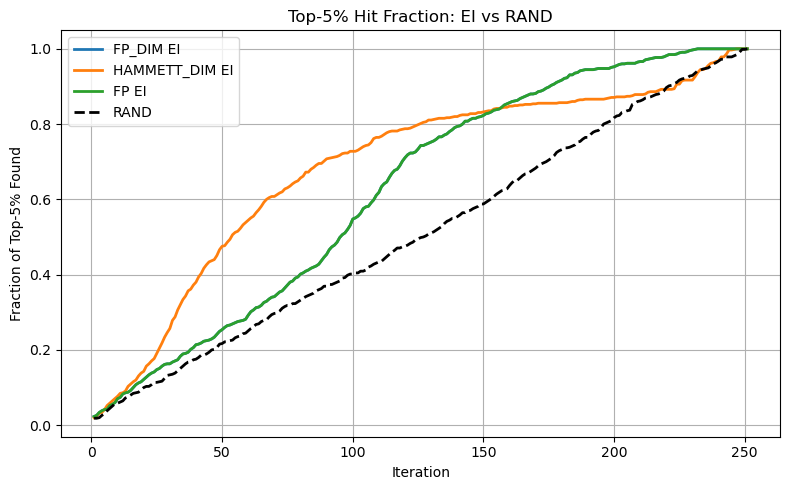

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_results(file_initials, metrics=('hits', 'regret', 'acq')):
    """
    file_initials: dict mapping descriptor names to the base filepath (without suffix)
                   e.g. {'FP': '/path/Hammett_fp', 'SL': '/path/Hammett_sl'}
    metrics:       tuple of metrics to load; supported: 'hits', 'regret', 'acq'
    returns:       dict of dicts: results[metric][descriptor] = DataFrame
    """
    results = {m: {} for m in metrics}
    for desc, base in file_initials.items():
        for m in metrics:
            fname = f"{base}_{m}.csv"
            if os.path.isfile(fname):
                df = pd.read_csv(fname, index_col=0)
                results[m][desc] = df
            else:
                print(f"Warning: file not found: {fname}")
    return results

def plot_hits_comparison(df_hits_dict):
    """
    df_hits_dict: dict mapping descriptor names to df_hits DataFrames
    """
    plt.figure(figsize=(8, 5))
    for desc, df in df_hits_dict.items():
        plt.plot(df.index, df.iloc[:, 0], label=desc)  # assumes single column or first column
    plt.xlabel("Iteration")
    plt.ylabel("Fraction of Top-5% Found")
    plt.title("Comparison of 5% Discovery Fraction Across Descriptors")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_acq_comparison(df_acq_dict):
    """
    df_acq_dict: dict mapping descriptor names to df_acq DataFrames
    """
    plt.figure(figsize=(8, 5))
    for desc, df in df_acq_dict.items():
        plt.plot(df.index, df.iloc[:, 0], label=desc)  # first acquisition method
    plt.xlabel("Iteration")
    plt.ylabel("Mean Acquisition Value")
    plt.title("Comparison of Acquisition Values Across Descriptors")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_regret_comparison(df_regret_dict):
    """
    df_regret_dict: dict mapping descriptor names to df_regret dicts
                    where df_regret_dict[desc] is a dict mapping method to DataFrame
    """
    for desc, methods_dict in df_regret_dict.items():
        for method, df in methods_dict.items():
            plt.figure(figsize=(6, 4))
            # plot sum or average over objectives
            avg_regret = df.mean(axis=1)
            plt.plot(df.index, avg_regret, label=f"{desc}-{method}")
            plt.xlabel("Iteration")
            plt.ylabel("Average Cumulative Regret")
            plt.title(f"{desc} - {method.upper()} Regret")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

import matplotlib.pyplot as plt

def plot_hits_by_method(df_hits_dict):
    """
    df_hits_dict: dict mapping descriptor names → DataFrame with columns ['lcb','ei','rand']
                  index が iteration
    例: {'FP': df_fp_hits, 'SL': df_sl_hits, 'Hammett': df_h_hits}
    """
    # まずメソッド一覧を取得
    methods = df_hits_dict[next(iter(df_hits_dict))].columns.tolist()
    
    for m in methods:
        plt.figure(figsize=(8,5))
        for desc, df in df_hits_dict.items():
            plt.plot(df.index, df[m], label=desc)
        plt.title(f"Top-5% Hit Fraction per Iteration ({m.upper()})")
        plt.xlabel("Iteration")
        plt.ylabel("Fraction of Top-5% Found")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def plot_hits_with_random_baseline(df_hits_dict):
    """
    df_hits_dict: dict mapping descriptor → DataFrame with columns ['lcb','ei','rand']
    各 descriptor ごとに、
      ・lcb vs rand
      ・ei  vs rand
    を同じグラフ上で比較します。
    """
    methods = ['lcb','ei']
    for m in methods:
        plt.figure(figsize=(8,5))
        for desc, df in df_hits_dict.items():
            # メインの獲得関数
            plt.plot(df.index, df[m],
                     label=f"{desc.upper()} {m.upper()}", linewidth=2)
            # ランダムベースライン
            plt.plot(df.index, df['rand'],
                     linestyle='--',
                     label=f"{desc.upper()} RAND")
        plt.title(f"Top-5% Hit Fraction: {m.upper()} vs RAND")
        plt.xlabel("Iteration")
        plt.ylabel("Fraction of Top-5% Found")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_hits_with_single_random(df_hits_dict):
    """
    df_hits_dict: dict mapping descriptor -> DataFrame with columns ['lcb','ei','rand']
    各メソッド（lcb, ei）ごとに、説明関数別の曲線と
    ランダム平均（RAND）を一つだけ重ねてプロットします。
    """
    # すべての descriptor から RAND 列の平均を計算
    any_desc = next(iter(df_hits_dict))
    iterations = df_hits_dict[any_desc].index.values
    rand_values = np.mean(
        [df['rand'].values for df in df_hits_dict.values()],
        axis=0
    )

    for m in ['lcb', 'ei']:
        plt.figure(figsize=(8,5))
        # 各説明関数の曲線
        for desc, df in df_hits_dict.items():
            plt.plot(
                df.index, df[m],
                label=f"{desc.upper()} {m.upper()}",
                linewidth=2
            )
        # ランダム平均を一度だけプロット
        plt.plot(
            iterations, rand_values,
            linestyle='--', color='black',
            label='RAND', linewidth=2
        )
        plt.title(f"Top-5% Hit Fraction: {m.upper()} vs RAND")
        plt.xlabel("Iteration")
        plt.ylabel("Fraction of Top-5% Found")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --- 使用例 ---
# results = load_results(file_initials, metrics=('hits','acq','regret'))
# plot_hits_with_single_random(results['hits'])



# --- Example usage ---
# 1) 検証した説明関数のベースファイル名を辞書で指定
file_initials = {
    'FP_dim':"../BO_result/target_relative/initsize5_LCB_per_dim/FP/FP_p_0.95_init5" ,
    "Hammett_dim": "../BO_result/target_relative/initsize5_LCB_per_dim/Hammett/Hammett_p_0.95_init5",
    "FP": "../BO_result/target_relative/initsize5_LCB/FP/FP_0.95_init5"
    
    # 他の説明関数も同様に追加
}

# 2) データ読み込み
results = load_results(file_initials, metrics=('hits', 'acq', 'regret'))
# 3) 比較プロット
plot_hits_with_single_random(results['hits'])



 


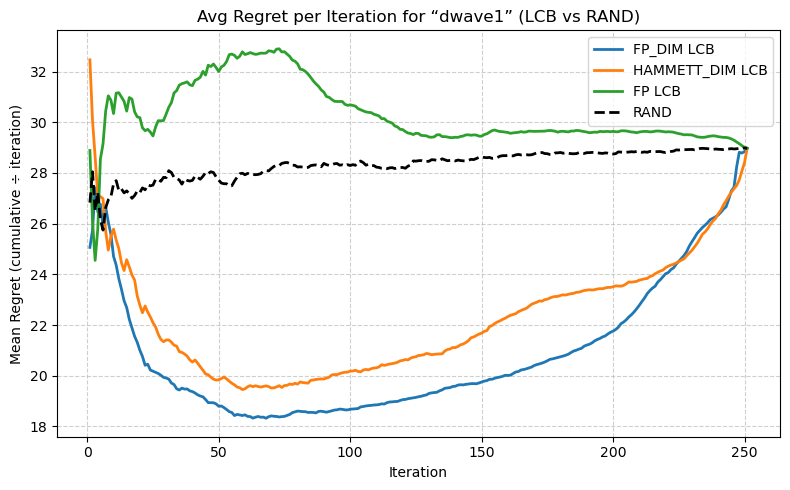

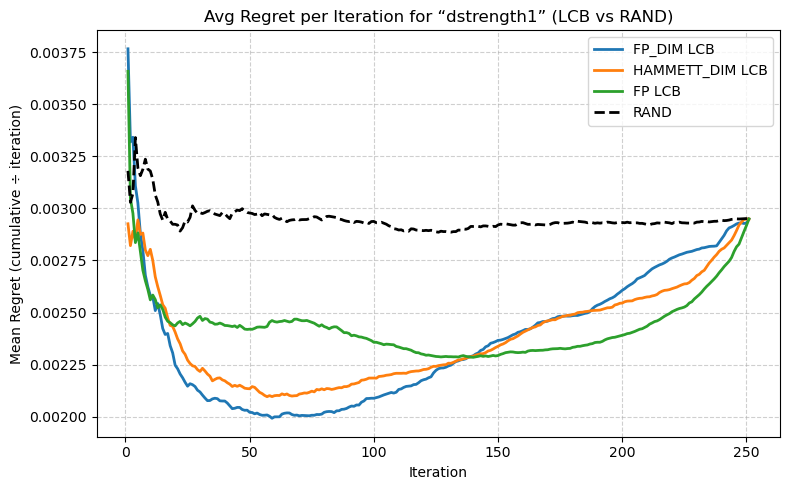

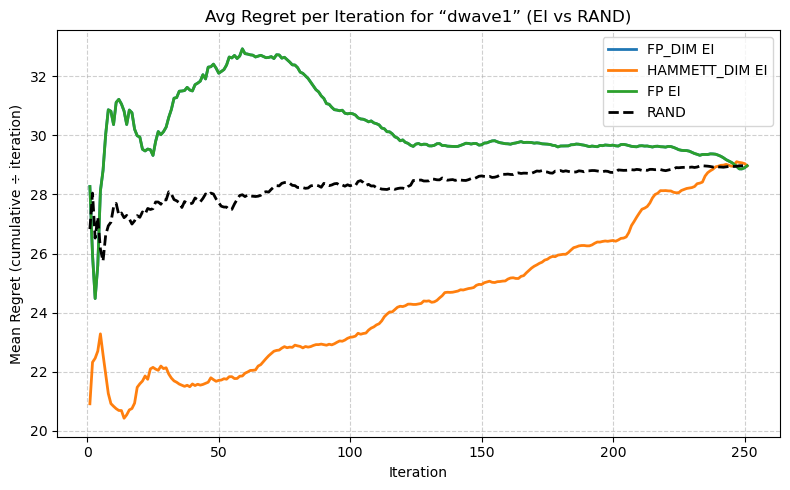

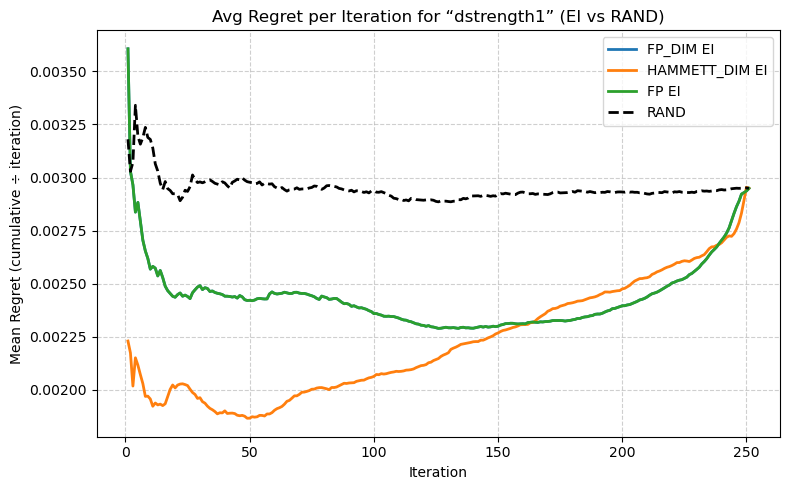

StopIteration: 

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_regret_by_method(file_initials, methods=('lcb','ei','rand')):
    """
    file_initials: dict mapping descriptor names to base file paths (without suffix)
    methods: tuple of acquisition methods
    returns: dict mapping method -> dict mapping descriptor -> DataFrame
    """
    results = {m: {} for m in methods}
    for desc, base in file_initials.items():
        for m in methods:
            fname = f"{base}_regret_{m}.csv"
            if os.path.isfile(fname):
                df = pd.read_csv(fname, index_col=0)
                results[m][desc] = df
            else:
                print(f"Warning: file not found: {fname}")
    return results
       
def plot_avg_regret_per_obj_with_rand(regret_results):
    """
    各獲得関数 (lcb, ei) × 各目的関数ごとに、
    各説明関数の平均後悔（累積後悔÷iteration）と
    RAND の平均後悔を同じグラフに表示します。

    Parameters
    ----------
    regret_results : dict
        load_regret_by_method の出力形式
        {'lcb': {'FP': df, ...},
         'ei':  {...},
         'rand': {...}}
    """
    rand_dict = regret_results['rand']
    # RAND の各目的関数ごとの平均累積後悔を計算
    # 目的関数一覧取得
    sample_rand_df = next(iter(rand_dict.values()))
    objectives = sample_rand_df.columns.tolist()

    # RAND 平均累積後悔DFを作成
    rand_avg_cum = pd.DataFrame(
        {desc: df[obj] for desc, df in rand_dict.items() for obj in objectives},
        index=sample_rand_df.index
    )
    # Actually, better to compute per objective:
    rand_avg_cum = pd.DataFrame({
        obj: pd.concat([df[obj] for df in rand_dict.values()], axis=1).mean(axis=1)
        for obj in objectives
    })
    
    for method in ['lcb', 'ei']:
        method_dict = regret_results[method]
        for obj in objectives:
            plt.figure(figsize=(8, 5))
            # 各説明関数
            for desc, df in method_dict.items():
                avg_regret = df[obj] / df.index
                plt.plot(df.index, avg_regret,
                         label=f"{desc.upper()} {method.upper()}",
                         linewidth=2)
            # RAND baseline
            rand_avg = rand_avg_cum[obj] / rand_avg_cum.index
            plt.plot(rand_avg.index, rand_avg.values,
                     linestyle='--', color='black', label='RAND', linewidth=2)
            
            plt.title(f"Avg Regret per Iteration for “{obj}” ({method.upper()} vs RAND)")
            plt.xlabel("Iteration")
            plt.ylabel("Mean Regret (cumulative ÷ iteration)")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()



regret_by_method = load_regret_by_method(file_initials)
# regret_by_method_LCB_dim = load_regret_by_method(file_initials_LCB_dim)
# regret_by_method_LCB_dim_init50 = load_regret_by_method(file_initials_init50)
# regret_by_method_LCB_dim_init100 = load_regret_by_method(file_initials_init100)
# # plot_regret_by_method(regret_by_method)
# plot_avg_regret_per_iter_by_method(regret_by_method)
# plot_avg_regret_per_obj_by_method(regret_by_method)
# plot_avg_regret_with_rand(regret_by_method)
plot_avg_regret_per_obj_with_rand(regret_by_method)
plot_avg_regret_per_obj_with_rand(regret_by_method_LCB_dim)
plot_avg_regret_per_obj_with_rand(regret_by_method_LCB_dim_init50)
plot_avg_regret_per_obj_with_rand(regret_by_method_LCB_dim_init100)
